In [2]:
import os
import pandas as pd
import numpy as np
from time import time
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score, train_test_split,GridSearchCV,RandomizedSearchCV
from keras.preprocessing.image import img_to_array, load_img, array_to_img
from keras.applications.vgg16 import VGG16
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import nltk
import string
import unidecode
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten,Dropout
from keras.layers.convolutional import Conv2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from livelossplot import PlotLossesKeras
from keras.optimizers import Adam
import tensorflow as tf
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ModelCheckpoint, EarlyStopping
nltk.download('wordnet')
nltk.download('stopwords')
%matplotlib inline
path = os.getcwd()
pathColor= '/Users/germancarvajal/Downloads'
dataTraining = pd.read_csv(os.path.join(path, 'data', 'dataTraining.csv'), encoding='UTF-8', index_col=0)

Using TensorFlow backend.


[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/germancarvajal/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/germancarvajal/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [109]:
Gray_Img_size=(64,40) #Size of the gray images to import 
Color_Img_size=(64,32) #Size of the color images to import with multiples of 32
words= 1000 #Number of text features to consider in the algorithm
Validation_percent = 0.2 #Fraction of data used for validation
Test_percent = 0.1 #Fraction of data used for test

In [4]:
wordnet_lemmatizer = WordNetLemmatizer()
def split_into_lemmas(text):
    text = unidecode.unidecode(text.lower())
    words = text.split()
    nopunc = [char for char in words if char not in string.punctuation]
    clean_mess = [word for word in nopunc if word not in stopwords.words('english')]
    return [wordnet_lemmatizer.lemmatize(word).encode('ascii') for word in clean_mess]

In [5]:
vect = CountVectorizer(ngram_range=(1, 2), max_features=words, analyzer=split_into_lemmas,binary=False)
X_txt = vect.fit_transform(dataTraining['plot'])
print('Text input size: ',X_txt.shape)
mlb = MultiLabelBinarizer()
Y = mlb.fit_transform(pd.Series(dataTraining['genres']).map(lambda x: eval(x)))
print('Labels input size: ',Y.shape)

('Text input size: ', (7895, 1000))
('Labels input size: ', (7895, 24))


In [6]:
Index_total=range(dataTraining.shape[0])
Index_int,Index_test=train_test_split(Index_total,test_size=Test_percent,random_state=123)
Index_train,Index_validation=train_test_split(Index_int,test_size=Validation_percent/(1-Test_percent),random_state=123)
del Index_int,Index_total
print('Training data: ',len(Index_train))
print('Validation data: ',len(Index_validation))
print('Test data: ',len(Index_test))

('Training data: ', 5526)
('Validation data: ', 1579)
('Test data: ', 790)


In [34]:
Text=Input(shape=(min(words,X_txt.shape[1]),),name='Text')
T1=Dense(256,activation='relu')(Text)
Drop1 = Dropout(0.5)(T1)
T2 = Dense(128, activation = 'relu')(Drop1)
Drop2 = Dropout(0.5)(T2)
T3 = Dense(64, activation = 'relu')(Drop2)
Drop3 = Dropout(0.5)(T3)
output = Dense(Y.shape[1], activation='sigmoid')(Drop3)

modelTxt = Model(inputs=Text, outputs=output)
modelTxt.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Text (InputLayer)            (None, 1000)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 256)               256256    
_________________________________________________________________
dropout_8 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               32896     
_________________________________________________________________
dropout_9 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 64)                8256      
_________________________________________________________________
dropout_10 (Dropout)         (None, 64)                0         
__________

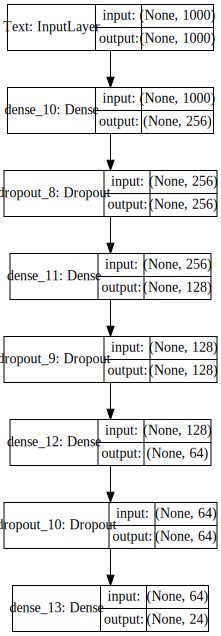

In [35]:
SVG(model_to_dot(modelTxt,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [36]:
adam = Adam(lr=0.001)
modelTxt.compile(optimizer = adam,loss='categorical_crossentropy',metrics=['accuracy'])
checkpointTxt = ModelCheckpoint('Txt-{epoch:02d}-{val_acc:.2f}.hdf5',monitor='val_acc',verbose=1,save_best_only=False,save_weights_only=True,mode='auto',period=2)
earlystopTxt = EarlyStopping(monitor='val_acc',min_delta=0,patience=50,verbose=1,mode='auto')
TrainingEpochsTxt=200
batch_sizeTxt=50

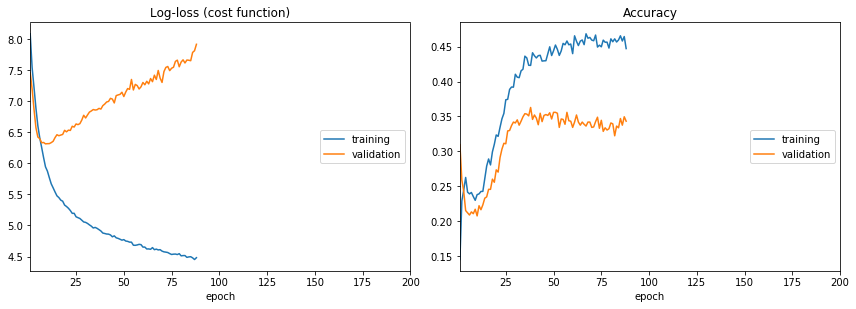


Epoch 00088: saving model to Txt-88-0.34.hdf5
Epoch 00088: early stopping


In [37]:
np.random.seed(123)
tf.set_random_seed(123)
modelTxt.fit(X_txt[Index_train],Y[Index_train],batch_size=batch_sizeTxt,epochs=TrainingEpochsTxt,verbose=1,validation_data=(X_txt[Index_validation],Y[Index_validation]),callbacks=[PlotLossesKeras(),checkpointTxt,earlystopTxt])

In [128]:
Y_pred_txt=modelTxt.predict(X_txt[Index_test])
roc_auc_score(Y[Index_test],Y_pred_txt,average='macro')

0.81077208861404959

In [42]:
dataTesting = pd.read_csv(os.path.join(path, 'data', 'dataTesting.csv'), encoding='UTF-8', index_col=0)
X_txt_pred = vect.transform(dataTesting['plot'])
predTxt=pd.DataFrame(modelTxt.predict(X_txt_pred,verbose=1),columns=['p_'+s for s in mlb.classes_],index=dataTesting.index)
predTxt.to_csv(path_or_buf ='modelTxt.csv',index_label='ID',encoding='UTF-8')

3383/3383 [==============================] - 0s 81us/step


In [46]:
def grayGenerator(iterableList,batch_size):
    while True:
        for j in range(-(-len(iterableList)/batch_size)):
            x_gray = np.full((batch_size,Gray_Img_size[0],Gray_Img_size[1],1),np.nan)
            n=0
            for i in iterableList[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]:
                img_g = load_img(os.path.join(path, 'images_resize_gray', str(dataTraining.index[i]) + '_resize_gray.jpeg'),target_size=Gray_Img_size,grayscale=True)
                x_g = img_to_array(img_g)
                x_g = x_g.reshape((1,) + x_g.shape)
                x_gray[n]=x_g
                n=n+1
            x_gray=x_gray[~np.isnan(x_gray).any(axis=(1,2,3))]
            yield x_gray,Y[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]

In [90]:
GrayImage = Input(shape=(Gray_Img_size[0],Gray_Img_size[1],1),name='Gray_Image')
cG1 = Conv2D(32, kernel_size=4, activation='relu')(GrayImage)
pG1 = MaxPooling2D(pool_size=(4, 4))(cG1)
cG2 = Conv2D(32, kernel_size=4, activation='relu')(pG1)
pG2 = MaxPooling2D(pool_size=(4, 4))(cG2)
flat = Flatten()(pG2)
G1=Dense(128,activation='relu')(flat)
G2=Dense(64,activation='relu')(G1)
output = Dense(Y.shape[1], activation='sigmoid')(G2)

modelGray = Model(inputs=GrayImage, outputs=output)
modelGray.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Gray_Image (InputLayer)      (None, 64, 40, 1)         0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 61, 37, 32)        544       
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 15, 9, 32)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 12, 6, 32)         16416     
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 3, 1, 32)          0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 96)                0         
_________________________________________________________________
dense_33 (Dense)             (None, 128)               12416     
__________

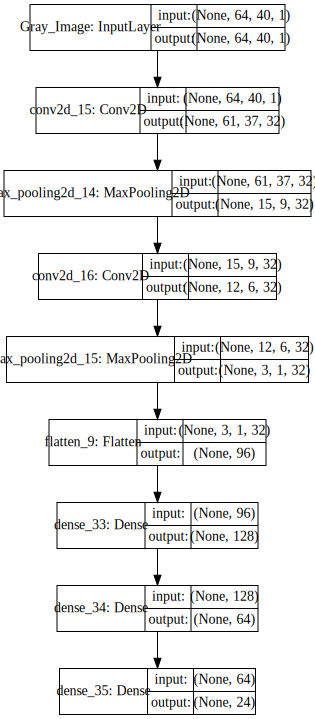

In [91]:
SVG(model_to_dot(modelGray,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [93]:
adam = Adam(lr=0.001)
modelGray.compile(optimizer = adam,loss='categorical_crossentropy',metrics=['accuracy'])
checkpointGray = ModelCheckpoint('Gray-{epoch:02d}-{val_acc:.2f}.hdf5',monitor='val_acc',verbose=1,save_best_only=False,save_weights_only=True,mode='auto',period=2)
earlystopGray = EarlyStopping(monitor='val_acc',min_delta=0,patience=10,verbose=1,mode='auto')
TrainingEpochsGray=100
batch_sizeGray=50
trGray=grayGenerator(Index_train,batch_sizeGray)
vlGray=grayGenerator(Index_validation,batch_sizeGray)

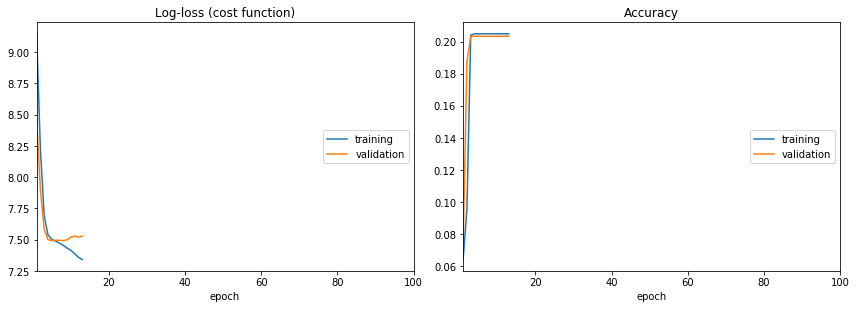

Epoch 00013: early stopping


In [94]:
np.random.seed(123)
tf.set_random_seed(123)
modelGray.fit_generator(trGray,steps_per_epoch=-(-len(Index_train)/batch_sizeGray),epochs=TrainingEpochsGray,verbose=1,validation_data=vlGray,validation_steps=-(-len(Index_validation)/batch_sizeGray),callbacks=[PlotLossesKeras(),checkpointGray,earlystopGray])

In [95]:
tsGray=grayGenerator(Index_test,batch_sizeGray)
Y_predGray=modelGray.predict_generator(tsGray,steps=-(-len(Index_test)/batch_sizeGray),verbose=1)

16/16 [==============================] - 1s 58ms/step


In [96]:
roc_auc_score(Y[Index_test],Y_predGray,average='macro')

0.51394793932133365

In [102]:
model_vgg16 = VGG16(include_top=False, weights='imagenet')
graph = tf.get_default_graph()

In [103]:
def colorGenerator(iterableList,batch_size):
    while True:
        for j in range(-(-len(iterableList)/batch_size)):
            x_color = np.full((batch_size,Color_Img_size[0]/32,Color_Img_size[1]/32,512),np.nan)
            n=0
            for i in iterableList[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]:
                img_c = load_img(os.path.join(pathColor, 'images', str(dataTraining.index[i]) + '.jpeg'),target_size=Color_Img_size,grayscale=False)
                x_c = img_to_array(img_c)
                x_c = x_c.reshape((1,) + x_c.shape)
                with graph.as_default():
                    x_vgg = model_vgg16.predict(x_c)
                x_color[n]=x_vgg
                n=n+1
            x_color=x_color[~np.isnan(x_color).any(axis=(1,2,3))]
            yield x_color,Y[j*batch_size:min(j*batch_size+batch_size,len(iterableList))]

In [110]:
VGG_out = Input(shape=(Color_Img_size[0]/32,Color_Img_size[1]/32,512),name='VGG16')
flatVGG = Flatten()(VGG_out)
C1 = Dense(256, activation='relu')(flatVGG)
C2 = Dense(64, activation='relu')(C1)
output = Dense(Y.shape[1], activation='sigmoid')(C2)

modelColor = Model(inputs=VGG_out, outputs=output)
modelColor.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
VGG16 (InputLayer)           (None, 2, 1, 512)         0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 1024)              0         
_________________________________________________________________
dense_46 (Dense)             (None, 256)               262400    
_________________________________________________________________
dense_47 (Dense)             (None, 64)                16448     
_________________________________________________________________
dense_48 (Dense)             (None, 24)                1560      
Total params: 280,408
Trainable params: 280,408
Non-trainable params: 0
_________________________________________________________________


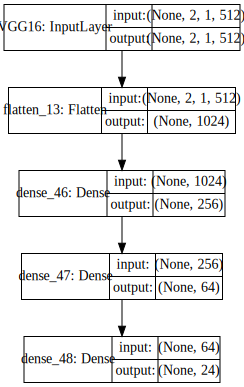

In [111]:
SVG(model_to_dot(modelColor,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [112]:
adam = Adam(lr=0.001)
modelColor.compile(optimizer = adam,loss='categorical_crossentropy',metrics=['accuracy'])
checkpointColor = ModelCheckpoint('Color-{epoch:02d}-{val_acc:.2f}.hdf5',monitor='val_acc',verbose=1,save_best_only=False,save_weights_only=True,mode='auto',period=2)
earlystopColor = EarlyStopping(monitor='val_acc',min_delta=0,patience=20,verbose=1,mode='auto')
TrainingEpochsColor=100
batch_sizeColor=50
trColor=colorGenerator(Index_train,batch_sizeColor)
vlColor=colorGenerator(Index_validation,batch_sizeColor)

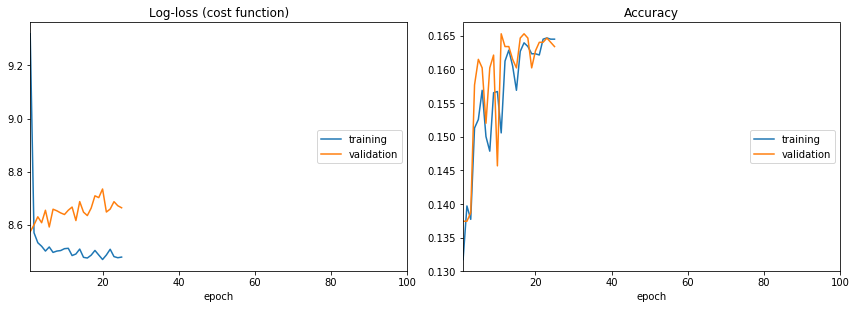

Epoch 26/100
 16/111 [===>..........................] - ETA: 1:18 - loss: 8.3705 - acc: 0.1475

KeyboardInterrupt: 

In [113]:
np.random.seed(123)
tf.set_random_seed(123)
modelColor.fit_generator(trColor,steps_per_epoch=-(-len(Index_train)/batch_sizeColor),epochs=TrainingEpochsColor,verbose=1,validation_data=vlColor,validation_steps=-(-len(Index_validation)/batch_sizeColor),callbacks=[PlotLossesKeras(),checkpointColor,earlystopColor])

In [114]:
tsColor=colorGenerator(Index_test,batch_sizeColor)
Y_predColor=modelColor.predict_generator(tsColor,steps=-(-len(Index_test)/batch_sizeColor),verbose=1)

16/16 [==============================] - 37s 2s/step


In [115]:
roc_auc_score(Y[Index_test],Y_predColor,average='macro')

0.51695628001611127

In [122]:
Input1=Input(shape=(24,))
Input2=Input(shape=(24,))
Input3=Input(shape=(24,))
merge=concatenate([Input1,Input2,Input3])
d1=Dense(32,activation='relu')(merge)
d2=Dense(10,activation='relu')(d1)
output=Dense(Y.shape[1],activation='sigmoid')(d2)
model=Model(inputs=[Input1,Input2,Input3],outputs=output)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 24)           0                                            
__________________________________________________________________________________________________
concatenate_4 (Concatenate)     (None, 72)           0           input_14[0][0]                   
                                                                 input_15[0][0]                   
          

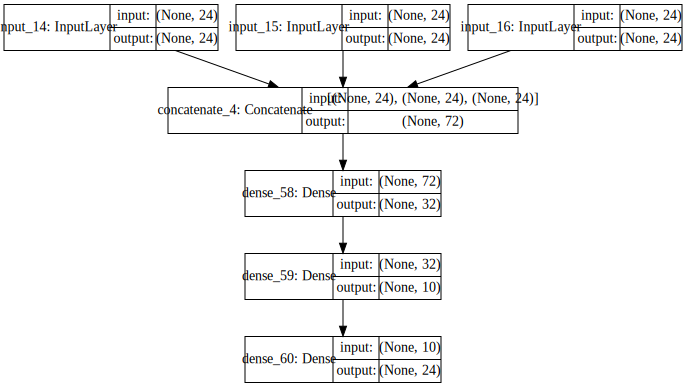

In [123]:
SVG(model_to_dot(model,show_layer_names=True,show_shapes=True).create(prog='dot', format='svg'))

In [132]:
adam = Adam(lr=0.001)
model.compile(optimizer = adam,loss='categorical_crossentropy',metrics=['accuracy'])
checkpoint = ModelCheckpoint('Model-{epoch:02d}-{val_acc:.2f}.hdf5',monitor='val_acc',verbose=1,save_best_only=False,save_weights_only=True,mode='auto',period=2)
earlystop = EarlyStopping(monitor='val_acc',min_delta=0,patience=20,verbose=1,mode='auto')
TrainingEpochs=100
batch_size=50

In [134]:
Y_pred_txt_tr=modelTxt.predict(X_txt[Index_train],verbose=1)
tsGray=grayGenerator(Index_train,batch_sizeGray)
Y_predGray_tr=modelGray.predict_generator(tsGray,steps=-(-len(Index_train)/batch_sizeGray),verbose=1)
tsColor=colorGenerator(Index_train,batch_sizeColor)
Y_predColor_tr=modelColor.predict_generator(tsColor,steps=-(-len(Index_train)/batch_sizeColor),verbose=1)

111/111 [==============================] - 227s 2s/step


In [147]:
Y_pred_txt_val=modelTxt.predict(X_txt[Index_validation],verbose=1)
tsGray=grayGenerator(Index_validation,batch_sizeGray)
Y_predGray_val=modelGray.predict_generator(tsGray,steps=-(-len(Index_validation)/batch_sizeGray),verbose=1)
tsColor=colorGenerator(Index_validation,batch_sizeColor)
Y_predColor_val=modelColor.predict_generator(tsColor,steps=-(-len(Index_validation)/batch_sizeColor),verbose=1)

32/32 [==============================] - 72s 2s/step


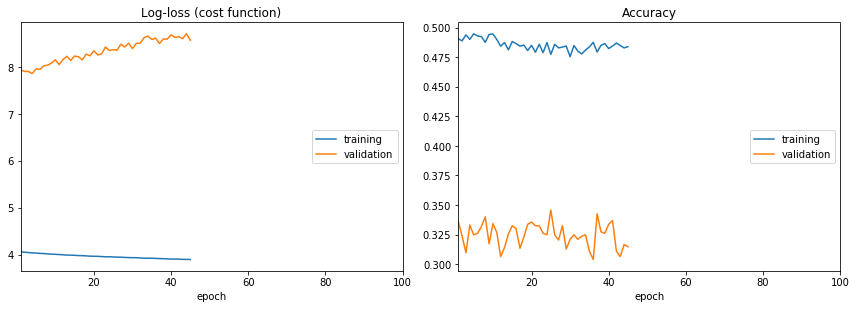

Epoch 00045: early stopping


In [148]:
np.random.seed(123)
tf.set_random_seed(123)
model.fit([Y_pred_txt_tr,Y_predGray_tr,Y_predColor_tr],Y[Index_train],epochs=TrainingEpochs,batch_size=batch_size,verbose=1,validation_data=([Y_pred_txt_val,Y_predGray_val,Y_predColor_val],Y[Index_validation]),callbacks=[PlotLossesKeras(),checkpoint,earlystop])

In [149]:
roc_auc_score(Y[Index_test],model.predict([Y_pred_txt,Y_predGray,Y_predColor]),average='macro')

0.79786155447961715